# Stable Diffusion 🎨 

This notebook shows an example of how to run `diffusers_interpret.StableDiffusionPipelineExplainer` to explain `diffusers.StableDiffusionPipeline`.

Before going through it, it is recommended to have a look at [🤗 HuggingFace's notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb#scrollTo=-xMJ6LaET6dT).

Explainability comes at a cost, **please note this notebook uses [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4) and the explainability method needs ~150GB RAM to run for that model on CPU or a GPU with more than 23GB VRAM** (GPU minimum requirements were not analyzed yet). Each additional `num_inference_steps` requires an additional ~5GB of RAM. We are using `num_inference_steps=15`.

### 1 - Initialize StableDiffusionPipeline normally

In [1]:
# make sure you're logged in with `huggingface-cli login`
import torch
from diffusers import StableDiffusionPipeline
from contextlib import nullcontext

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    use_auth_token=True,
    
    # FP16 is not working for 'cpu'
    revision='fp16' if device != 'cpu' else None,
    torch_dtype=torch.float16 if device != 'cpu' else None
).to(device)

### 2 - Pass StableDiffusionPipeline to StableDiffusionPipelineExplainer

In [2]:
from diffusers_interpret import StableDiffusionPipelineExplainer

explainer = StableDiffusionPipelineExplainer(pipe)

### 3 - Generate an image with the StableDiffusionPipelineExplainer object

Note that the `explainer()` method accepts all the arguments that `pipe()` accepts. 

We also pass a `generator` argument so that we get a deterministic output.

In [3]:
prompt = "A cute corgi with the Eiffel Tower in the background"

generator = torch.Generator(device).manual_seed(2022)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt, 
        num_inference_steps=15, 
        generator=generator
    )

Diffusion process:   0%|          | 0/17 [00:00<?, ?it/s]

Calculating token attributions... Done!


#### 3.1 - Check final generated image

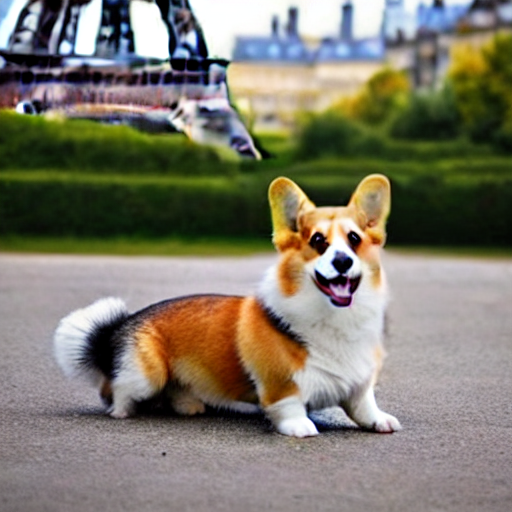

In [4]:
# Final image
output['sample']

#### 3.2 -  Check all the generated images during the diffusion process

In [5]:
output['all_samples_during_generation'].show()

You can also check the images individually:

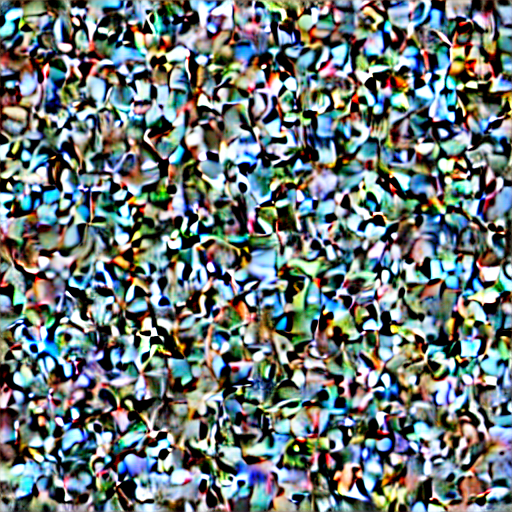

In [6]:
# Image at first generation 
output['all_samples_during_generation'][0]

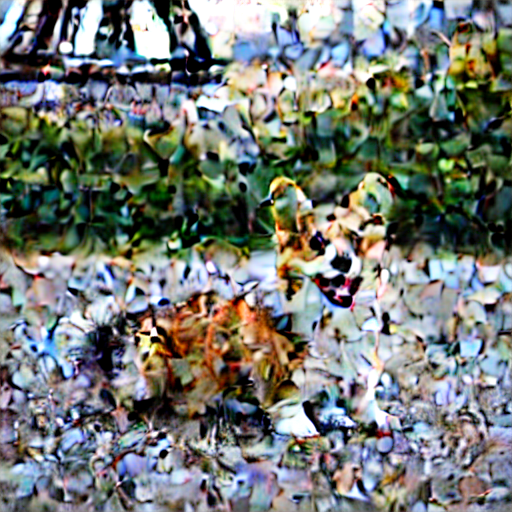

In [7]:
output['all_samples_during_generation'][10]

#### 3.3 - Check the normalized and unnormalized token attributions 

We are now able to see what were the importances of each token in the input text to generate when generating the image.

The token `mars` was the most important feature according to our explainability method.

In [8]:
# (token, attribution)
output['token_attributions']

[('a', 1061.3192),
 ('cute', 415.42422),
 ('corgi', 6440.731),
 ('with', 1854.0284),
 ('the', 1211.133),
 ('eiffel', 4759.964),
 ('tower', 4482.775),
 ('in', 2449.0667),
 ('the', 655.34204),
 ('background', 4003.131)]

In [9]:
# (token, attribution_percentage)
output['normalized_token_attributions']

[('a', 3.883),
 ('cute', 1.52),
 ('corgi', 23.564),
 ('with', 6.783),
 ('the', 4.431),
 ('eiffel', 17.415),
 ('tower', 16.401),
 ('in', 8.96),
 ('the', 2.398),
 ('background', 14.646)]

### 4 - Get explanations for a specific part of the image

`diffusers-interpret` also computes the tokens importances for generating a particular part of the output image.

In the current implementation, we only need to re-run the `explainer` and pass it the `explanation_2d_bounding_box` argument with the bounding box we are interested in seeing.

In [10]:
generator = torch.Generator(device).manual_seed(2022)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt, 
        num_inference_steps=15, 
        generator=generator,
        explanation_2d_bounding_box=((70, 180), (400, 435)), # (upper left corner, bottom right corner)
    )

Diffusion process:   0%|          | 0/17 [00:00<?, ?it/s]

Calculating token attributions... Done!


#### 4.1 - Check generated image

A red bounding box is now visible in the picture, to indicate the area that `explainer` is looking at when calculating the token attributions.

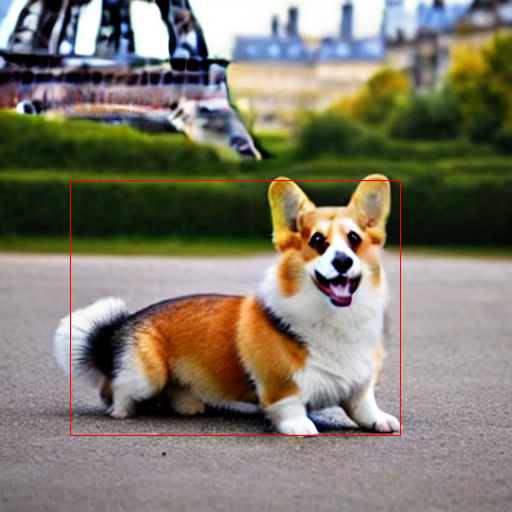

In [11]:
output['sample']

#### 4.2 - Check token attributions for bounding box

In [12]:
# (token, attribution_percentage)
output['normalized_token_attributions']

[('a', 1.89),
 ('cute', 1.347),
 ('corgi', 23.152),
 ('with', 12.005),
 ('the', 7.991),
 ('eiffel', 5.143),
 ('tower', 11.555),
 ('in', 11.99),
 ('the', 1.873),
 ('background', 23.053)]

#### 4.3 - Only calculate attributions for last N steps of the generation

The diffusion process takes some steps and you might be interested in analying only from a particular step, when the image was less 'noisy'. You can do that by calling `explainer` with the `n_last_inference_steps_to_consider` argument. 

Below we run compute the token attributions for `n_last_inference_steps_to_consider=1`. 

In [13]:
generator = torch.Generator(device).manual_seed(2022)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt, 
        num_inference_steps=15, 
        generator=generator,
        explanation_2d_bounding_box=((70, 180), (400, 435)), # (upper left corner, bottom right corner)
        n_last_inference_steps_to_consider=1
    )

Diffusion process:   0%|          | 0/17 [00:00<?, ?it/s]

Calculating token attributions... Done!


In [14]:
output['normalized_token_attributions']

[('a', 1.061),
 ('cute', 1.316),
 ('corgi', 33.946),
 ('with', 5.567),
 ('the', 2.096),
 ('eiffel', 16.677),
 ('tower', 27.736),
 ('in', 3.011),
 ('the', 0.865),
 ('background', 7.726)]

### 5 - Same generation, but with a different `explanation_2d_bounding_box`

In [15]:
generator = torch.Generator(device).manual_seed(2022)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt, 
        num_inference_steps=15, 
        generator=generator,
        explanation_2d_bounding_box=((0, 0), (270, 165)) # (upper left corner, bottom right corner)
    )

Diffusion process:   0%|          | 0/17 [00:00<?, ?it/s]

Calculating token attributions... Done!


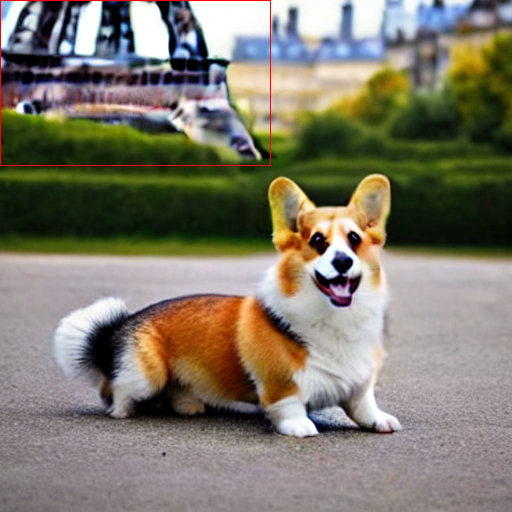

In [16]:
output['sample']

In [17]:
# (token, attribution_percentage)
output['normalized_token_attributions']

[('a', 2.23),
 ('cute', 1.17),
 ('corgi', 21.083),
 ('with', 8.81),
 ('the', 6.125),
 ('eiffel', 13.979),
 ('tower', 23.825),
 ('in', 6.052),
 ('the', 1.491),
 ('background', 15.236)]

Repeating the process, but only for the last generation step.

In [18]:
generator = torch.Generator(device).manual_seed(2022)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt, 
        num_inference_steps=15, 
        generator=generator,
        explanation_2d_bounding_box=((0, 0), (270, 165)), # (upper left corner, bottom right corner)
        n_last_inference_steps_to_consider=1
    )

Diffusion process:   0%|          | 0/17 [00:00<?, ?it/s]

Calculating token attributions... Done!


In [19]:
# (token, attribution_percentage)
output['normalized_token_attributions']

[('a', 4.875),
 ('cute', 2.551),
 ('corgi', 16.901),
 ('with', 4.164),
 ('the', 2.42),
 ('eiffel', 29.703),
 ('tower', 30.112),
 ('in', 3.956),
 ('the', 0.838),
 ('background', 4.481)]